<a href="https://colab.research.google.com/github/YuxinZhang9615/NYC-Yellow-Taxi-Data-Challenge/blob/master/NYC_Yellow_Taxi_Data_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

- **Data**: I used the NYC 2017 yellow taxi data, the taxi zone shapefiles, and the historical NYC weather data.
- **Goal**: Analyze and predict the pickup rate of NYC yellow taxi based on time, pickup location, and weather.
- **Conclusion**: There are interesting monthly, weekly, daily and hourly patterns and geographic pattern of the pickup rate, which is discussed in Section 2. Data Exploration. Weather seems to have some relationship with the pickup rate and is also discussed in Section 2.
- **Model and Result**: Random Forest -> R-square:  0.9364 (could be further improved with more training)

# 0. Load Packages

In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from __future__ import division
from sklearn.metrics import mean_squared_error
from math import sqrt

pd.set_option('display.float_format', lambda x: '%0.2f' %x)
pd.set_option('display.max_columns', 500)
sns.set(rc={'figure.figsize':(6,4)})
%matplotlib inline

# 1: Data Preparation

In Section 1.1, I load the data for one month only to get an overview of the data. <br>
In Section 1.2, I load the monthly data for 2017 the whole year. 

## 1.1 Explore January Only

Load January data to get a general idea. 
I discovered that there are following particular cases:
- trip_distance = 0: There were 0.6% of rows and I deleted them.
- fares < 0: Based on a quick explore in Excel, I observed that for each row with negative fares there is another row containing positive fares with the same information and positive fares with the same absolute value and they always cancel out. Therefore, it may be some kind of discount or cancellation. I kept only the positive rows for the sake of counts.
- Given new feature time_diff = diff(dropoff_time, pickup_datetime), there are a few cases with negative time difference, or trips that take too short like seconds or too long like almost a day. I deleted 4 rows with negative time_diff, 0.08% of rows with time_diff < 1 minute, and 0.01% of rows with time_diff > 6hrs.

In [0]:
df01 = pd.read_csv('yellow_tripdata_2017-01.csv', header = 0)
df01.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2017-01-09 11:13:28,2017-01-09 11:25:45,1,3.30,1,N,263,161,1,12.50,0.00,0.50,2.00,0.00,0.30,15.30
1,1,2017-01-09 11:32:27,2017-01-09 11:36:01,1,0.90,1,N,186,234,1,5.00,0.00,0.50,1.45,0.00,0.30,7.25
2,1,2017-01-09 11:38:20,2017-01-09 11:42:05,1,1.10,1,N,164,161,1,5.50,0.00,0.50,1.00,0.00,0.30,7.30
3,1,2017-01-09 11:52:13,2017-01-09 11:57:36,1,1.10,1,N,236,75,1,6.00,0.00,0.50,1.70,0.00,0.30,8.50
4,2,2017-01-01 00:00:00,2017-01-01 00:00:00,1,0.02,2,N,249,234,2,52.00,0.00,0.50,0.00,0.00,0.30,52.80


In [0]:
print("Number of rows: " + str(df01.shape[0]))
print("Number of columns: " + str(df01.shape[1]))

Number of rows: 9710124
Number of columns: 17


In [0]:
df01.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,9710124.00,9710124.00,9710124.00,9710124.00,9710124.00,9710124.00,9710124.00,9710124.00,9710124.00,9710124.00,9710124.00,9710124.00,9710124.00,9710124.00
mean,1.55,1.63,2.81,1.04,164.11,161.76,1.34,12.37,0.32,0.50,1.75,0.28,0.30,15.53
std,0.50,1.27,3.61,0.51,66.65,70.67,0.49,265.23,0.44,0.05,2.57,1.64,0.01,265.35
min,1.00,0.00,0.00,1.00,1.00,1.00,1.00,-350.00,-55.20,-0.50,-41.00,-15.00,-0.30,-350.30
25%,1.00,1.00,0.95,1.00,114.00,107.00,1.00,6.50,0.00,0.50,0.00,0.00,0.30,8.30
50%,2.00,1.00,1.60,1.00,162.00,162.00,1.00,9.00,0.00,0.50,1.30,0.00,0.30,11.30
75%,2.00,2.00,2.90,1.00,233.00,234.00,2.00,13.50,0.50,0.50,2.26,0.00,0.30,16.75
max,2.00,9.00,264.71,99.00,265.00,265.00,5.00,625900.80,55.54,56.50,999.99,911.08,0.30,625901.60


### 1.1.1 Data Exploration and Cleaning

In [0]:
df01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9710124 entries, 0 to 9710123
Data columns (total 17 columns):
VendorID                 int64
tpep_pickup_datetime     object
tpep_dropoff_datetime    object
passenger_count          int64
trip_distance            float64
RatecodeID               int64
store_and_fwd_flag       object
PULocationID             int64
DOLocationID             int64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 1.2+ GB


There is no missing data.

In [0]:
#how many rows have trip_distance = 0 or fare < 0
print(sum(df01.trip_distance == 0))
print(sum(df01.fare_amount < 0))

58672
4541


In [0]:
#Create time_diff representing the time duration of a ride
df01.tpep_pickup_datetime = pd.to_datetime(df01.tpep_pickup_datetime)
df01.tpep_dropoff_datetime = pd.to_datetime(df01.tpep_dropoff_datetime)

df01['time_diff'] = (df01.tpep_dropoff_datetime - df01.tpep_pickup_datetime)
df01['time_diff'].describe()

count                   9710124
mean     0 days 00:14:50.626451
std      0 days 00:55:02.051663
min          -42 days +01:19:45
25%             0 days 00:06:14
50%             0 days 00:10:18
75%             0 days 00:16:41
max             0 days 23:59:56
Name: time_diff, dtype: object

In [0]:
#How many data have time_diff < 0
print(sum(df01.tpep_dropoff_datetime < df01.tpep_pickup_datetime))
df01.loc[df01.tpep_dropoff_datetime < df01.tpep_pickup_datetime]

4


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,time_diff
4187748,1,2017-01-20 15:15:12,2017-01-18 15:47:45,1,3.20,1,N,52,232,1,12.50,0.50,0.50,2.00,0.00,0.30,15.80,-2 days +00:32:33
4557704,1,2017-01-21 15:20:28,2016-12-10 16:40:13,1,20.50,2,N,132,141,1,52.00,4.50,0.50,0.00,5.54,0.30,62.84,-42 days +01:19:45
5123974,1,2017-01-10 15:15:25,2017-01-06 00:23:28,1,3.00,1,N,246,239,1,13.00,0.00,0.50,2.75,0.00,0.30,16.55,-5 days +09:08:03
9035405,1,2017-01-29 18:03:04,2017-01-28 17:23:39,2,2.10,1,N,151,142,1,12.00,0.00,0.50,2.55,0.00,0.30,15.35,-2 days +23:20:35


In [0]:
#how many data have time_diff < 1 min or time_diff > 6 hrs
print(sum(df01.tpep_dropoff_datetime < df01.tpep_pickup_datetime + pd.Timedelta('1 min')))
print(sum(df01.tpep_dropoff_datetime > df01.tpep_pickup_datetime + pd.Timedelta('360 min')))

80032
13162


### 1.1.2 Feature Engineering

Since I care about the pick up counts per hour, I created a new column named 'counts' using groupby and ignored the columns regarding fare.

In [0]:
#create new feature 'counts' using groupby and features 'Month', 'Day', 'Day of week', 'Hour' from pickup time
df01['tpep_pickup_datetime'] = pd.to_datetime(df01['tpep_pickup_datetime'])
df01['Month'] = df01['tpep_pickup_datetime'].dt.month
df01['Day'] = df01['tpep_pickup_datetime'].dt.day
df01['Hour'] = df01['tpep_pickup_datetime'].dt.hour
df01['pick_dayofweek'] = df01['tpep_pickup_datetime'].dt.dayofweek
df01 = df01.groupby(['Month','Day','Hour','pick_dayofweek','PULocationID']).size().reset_index(name='counts')

df01.head()

,Month,Day,Hour,pick_dayofweek,PULocationID,counts
0,1,1,0,6,4,136
1,1,1,0,6,7,78
2,1,1,0,6,12,3
3,1,1,0,6,13,104
4,1,1,0,6,14,4


## 1.2 Data Prepration for 2017 whole year

This contains all the data in 2017. <br>
I loaded the monthly data using a for loop and performed data cleaning and feature engineering for each month in the loop to save memory, since loading all the data at once would be too large for the computer but the data after transformation is computable. <br>
I did data cleaning based on my discovery from January's data. And since I care about the pick up counts per hour, I created a new column named 'counts' using groupby and ignored the columns regarding fares. 

In [0]:
import glob
allFiles = glob.glob("yellow_tripdata_2017-" + "*.csv")

list_ = []

for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    
    #data cleaning based on time_diff, trip_distance, and fares
    df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
    df = df.loc[(df.tpep_dropoff_datetime < df.tpep_pickup_datetime + pd.Timedelta('360 min')) &
                (df.tpep_dropoff_datetime > df.tpep_pickup_datetime + pd.Timedelta('1 min')) &
                (df.trip_distance > 0) & (df.fare_amount > 0)]
    
    #drop unecessary columns to reduce the computation
    df = df.drop(['VendorID','fare_amount','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','total_amount'],
                 axis = 1)
    
    #create new feature 'counts' using groupby and features 'Month', 'Day', 'Day of week', 'Hour' from pickup time
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['Month'] = df['tpep_pickup_datetime'].dt.month
    df['Day'] = df['tpep_pickup_datetime'].dt.day
    df['Hour'] = df['tpep_pickup_datetime'].dt.hour
    df['pick_dayofweek'] = df['tpep_pickup_datetime'].dt.dayofweek
    df = df.groupby(['Month','Day','Hour','pick_dayofweek','PULocationID']).size().reset_index(name='counts')
    list_.append(df)
    del df
    print(file_ + '      loaded')

frame = pd.concat(list_, axis = 0, ignore_index = True)
del list_
del allFiles

yellow_tripdata_2017-01.csv      loaded
yellow_tripdata_2017-03.csv      loaded
yellow_tripdata_2017-02.csv      loaded
yellow_tripdata_2017-12.csv      loaded
yellow_tripdata_2017-06.csv      loaded
yellow_tripdata_2017-07.csv      loaded
yellow_tripdata_2017-05.csv      loaded
yellow_tripdata_2017-11.csv      loaded
yellow_tripdata_2017-10.csv      loaded
yellow_tripdata_2017-04.csv      loaded
yellow_tripdata_2017-09.csv      loaded
yellow_tripdata_2017-08.csv      loaded


# 2. Data Exploration: 

## 2.1 Overview

The dimension of the new working data set matches with our estimation so the data transformation process was performed correctly.
<br>
Therefore, the new data set is ready to use!

In [0]:
#check if the sum of counts matches with the dimension of our raw data, which should be around 110000000.
print("Number of tripdata records: ", str(sum(frame.counts)))
print("Number of rows in the new working dataset: ", str(frame.shape[0]))
print("Number of columns in the new working dataset: ", str(frame.shape[1]))

('Number of tripdata records: ', '112121103')
('Number of rows in the new working dataset: ', '1030537')
('Number of columns in the new working dataset: ', '6')


In [0]:
frame.describe()

,Month,Day,Hour,pick_dayofweek,PULocationID,counts
count,1030537.00,1030537.00,1030537.00,1030537.00,1030537.00,1030537.00
mean,6.50,15.70,11.61,3.07,141.23,108.80
std,3.44,8.80,6.95,2.01,76.82,179.81
min,1.00,1.00,0.00,0.00,1.00,1.00
25%,4.00,8.00,6.00,1.00,75.00,2.00
50%,6.00,16.00,12.00,3.00,143.00,17.00
75%,9.00,23.00,18.00,5.00,216.00,145.00
max,12.00,31.00,23.00,6.00,265.00,2910.00


## 2.2 Understand the predict variable

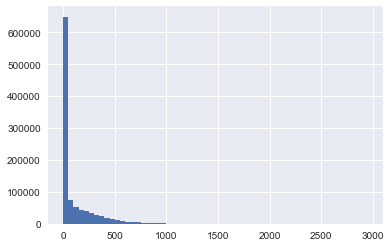

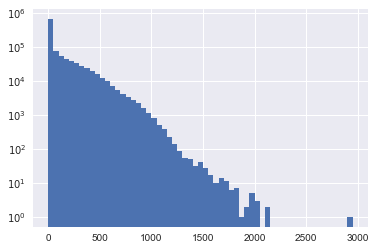

In [0]:
plt.hist(frame.counts, bins = range(0, 3000, 50))
plt.show()

plt.hist(frame.counts, bins = range(0, 3000, 50), log = True)
plt.show()

### 2.2.1 Exclude Outlier

A few outliers were excluded because with some further investigation, I discovered that they were abnormal.

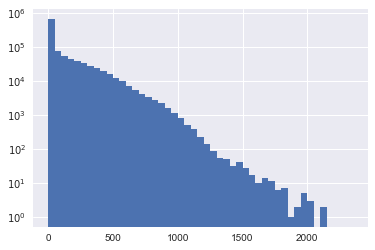

In [0]:
frame = frame[frame.counts < 2400]
plt.hist(frame.counts, bins = range(0, 2400, 50), log = True)
plt.show()

## 2.3 Understand the Features

## 2.3.1 Time Information

- Month of year: It seems the pick up rate is the lowest in summer months June, July, and August, and the highest in winter months January, February, and even March. 

- Day of month: Some days seem to have more pick ups, but overall, there is no obvious pattern.

- Day of week: Monday through Thursday seem to have very similar pick up counts. From Friday to Sunday, the pick up count is higher and higher. Saturday and Sunday obviously show a higher pick up count than other days and Sunday has the highest pick ups.

- Hour of day: There are obvious changes in pick up count during a day. 1 am seems to have the highest pick up count. It drops quickly between 2am and 5am and reaches the lowest of a day at 5 am. Then it rises. It remains stable through out the day except a small morning peak at 8 am, a small drop at 4pm and a small evening peak at 6pm. Then it rises again at night. It supports our common sense of a regular day-to-day pattern.

- Hour of day & Day of week: From the heatmap, we can see clearly that Monday - Friday follows the same day-to-day pattern, and weekend days Saturday - Sunday shows a 2 hour's delay, which is reasonable since people tend to start their day later on weekends and stay up late.

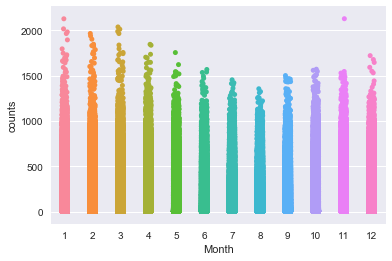

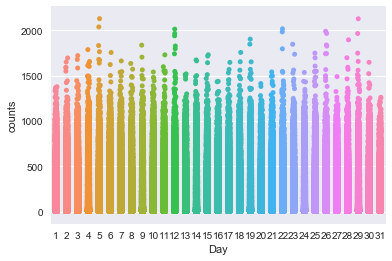

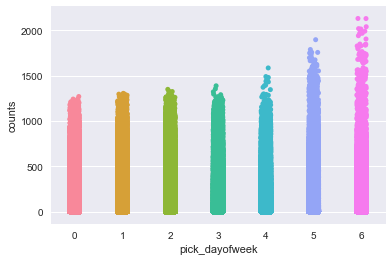

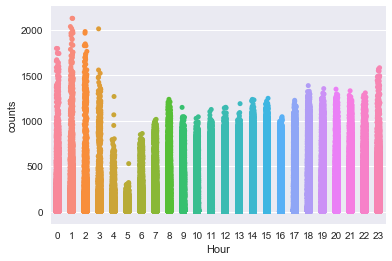

In [0]:
sns.stripplot(x='Month', y='counts', data=frame, jitter=True)
plt.show()

sns.stripplot(x='Day', y='counts', data=frame, jitter=True)
plt.show()

sns.stripplot(x='pick_dayofweek', y='counts', data=frame, jitter=True)
plt.show()

sns.stripplot(x='Hour', y='counts', data=frame, jitter=True)
plt.show()

In [0]:
df_weekday_hr = pd.DataFrame(index=range(24), columns=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
for i in range(24):
    for j in range(7):
        df_weekday_hr.iloc[i, j] = sum(frame.loc[(frame.pick_dayofweek == j) & (frame.Hour == i)].counts)
df_weekday_hr = df_weekday_hr.astype(str).astype(int)       

There is a clear 2-hours' delay of the daily pattern on weekends.

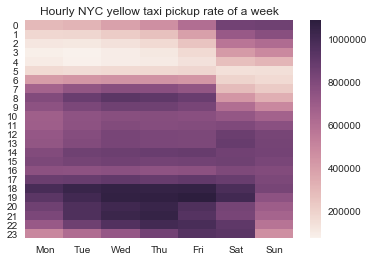

In [0]:
sns.set(rc={'figure.figsize':(6,4)})
sns.heatmap(df_weekday_hr)
plt.title('Hourly NYC yellow taxi pickup rate of a week')
plt.show()

In [0]:
vector = frame.groupby(['Month','Day','Hour'])['counts'].sum()

In [0]:
matrix = vector.values.reshape((365,24))

Summer months are lighter than other months. And we can explore further on the light days to see what is the reason. Are they holidays?

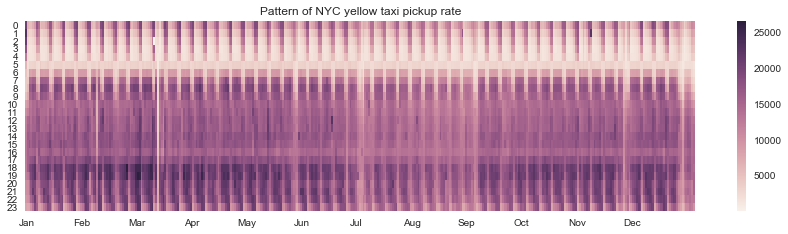

In [0]:
p = sns.set(rc={'figure.figsize':(15,3.5)})
p = sns.heatmap(matrix.transpose(), xticklabels = 30)
p.set(xticklabels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title('Pattern of NYC yellow taxi pickup rate')
plt.show()

### 2.3.2 Geographical Information

With a simple stripplot we can see the pickup count is very different among different locations. And with a bit of work on the shape files, a map was plotted. It shows that Manhattan, JFK airport, and LaGuardia Airport have a significantly higher pickup count compared to other areas.

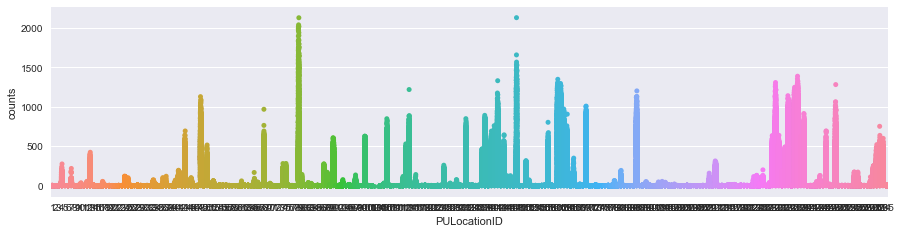

In [0]:
sns.stripplot(x='PULocationID', y='counts', data=frame, jitter=True)
plt.show()

In [0]:
import geopandas as gpd

# set the filepath and load in a shapefile
fp = './taxi_zones/taxi_zones.shp'
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.12,0.00,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,..."
1,2,0.43,0.00,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1..."
2,3,0.08,0.00,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,..."
3,4,0.04,0.00,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
4,5,0.09,0.00,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ..."


In [0]:
#map_df.plot()

In [0]:
frame_geo = frame.groupby('PULocationID')['counts'].sum().reset_index(name='counts')
frame_geo.head()

,PULocationID,counts
0,1,812
1,2,91
2,3,278
3,4,285422
4,5,10


In [0]:
# join the geodataframe with the cleaned up csv dataframe
merged = map_df.set_index('LocationID').join(frame_geo.set_index('PULocationID'))
merged.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry,counts
1,1,0.12,0.00,Newark Airport,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",812
2,2,0.43,0.00,Jamaica Bay,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",91
3,3,0.08,0.00,Allerton/Pelham Gardens,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",278
4,4,0.04,0.00,Alphabet City,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",285422
5,5,0.09,0.00,Arden Heights,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",10


In [0]:
merged['counts'] = merged['counts'].fillna(0)
merged.describe()

,OBJECTID,Shape_Leng,Shape_Area,counts
count,263.00,263.00,263.00,263.00
mean,132.00,0.09,0.00,420240.26
std,76.07,0.05,0.00,959316.44
min,1.00,0.01,0.00,1.00
25%,66.50,0.05,0.00,591.00
50%,132.00,0.08,0.00,2959.00
75%,197.50,0.12,0.00,117038.50
max,263.00,0.43,0.00,4410110.00


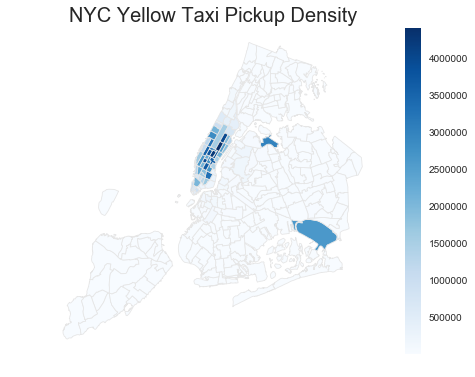

In [0]:
# set a variable that will call the column we want to visualise on the map
variable = 'counts'
# set the range for the choropleth
vmin, vmax = 1, 4410110
# create figure and axes for Matplotlib

fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column='counts', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.9')
ax.axis('off')
# add a title
ax.set_title('NYC Yellow Taxi Pickup Density', fontdict={'fontsize': '20', 'fontweight' : '3'})
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

## 2.4 Outside Data - Weather

Weather of a day may affect the pickup rate, so 9 features on Temperature, Humidity, Precipitation, Snowfall, Sunshine, Wind were included here. Data source is from Meteoblue website. https://www.meteoblue.com/en/weather/archive/export/basel_switzerland_2661604?daterange=2017-01-01+to+2017-12-31&params=&params%5B%5D=11%3B2+m+above+gnd&params%5B%5D=52%3B2+m+above+gnd&params%5B%5D=660%3Bsfc&params%5B%5D=677%3Bsfc&params%5B%5D=191%3Bsfc&params%5B%5D=204%3Bsfc&params%5B%5D=32%3B10+m+above+gnd%3B31%3B10+m+above+gnd&params%5B%5D=180%3Bsfc&utc_offset=1&aggregation=hourly&temperatureunit=FAHRENHEIT&windspeedunit=MILE_PER_HOUR
<br><br>
It seems there may be some relationships between weather and the pickup rate. For example, cold weather has higher pickup rate compared to warm weather, although when the temperature is too cold, below 22 fahrenheit, the pickup rate is extremely low.

In [0]:
weather = pd.read_csv('weather.csv', header = 0, sep = ';', skiprows = 11)
weather.head()

,Year,Month,Day,Hour,Minute,Temperature [2 m above gnd],Relative Humidity [2 m above gnd],Total Precipitation (high resolution) [sfc],Snowfall Amount (high resolution) [sfc],Sunshine Duration [sfc],Shortwave Radiation [sfc],Wind Speed [10 m above gnd],Wind Direction [10 m above gnd],Wind Gust [sfc]
0,2017,1,1,0,0,38.10,63.00,0.00,0.00,-999.00,0.00,3.67,127.57,1.34
1,2017,1,1,1,0,38.08,60.00,0.00,0.00,0.00,0.00,3.72,122.74,0.89
2,2017,1,1,2,0,38.10,58.00,0.00,0.00,0.00,0.00,3.98,128.16,1.34
3,2017,1,1,3,0,38.21,54.00,0.00,0.00,0.00,0.00,3.50,116.57,0.89
4,2017,1,1,4,0,37.36,56.00,0.00,0.00,0.00,0.00,4.03,109.44,10.29


In [0]:
weather = weather.drop(['Year','Minute'], axis = 1)

#merge two datasets
frame = frame.join(weather.set_index(['Month','Day','Hour']), on=['Month','Day','Hour'], how='left')
frame.head()

,Month,Day,Hour,pick_dayofweek,PULocationID,counts,Temperature [2 m above gnd],Relative Humidity [2 m above gnd],Total Precipitation (high resolution) [sfc],Snowfall Amount (high resolution) [sfc],Sunshine Duration [sfc],Shortwave Radiation [sfc],Wind Speed [10 m above gnd],Wind Direction [10 m above gnd],Wind Gust [sfc]
0,1,1,0,6,4,135,38.10,63.00,0.00,0.00,-999.00,0.00,3.67,127.57,1.34
1,1,1,0,6,7,77,38.10,63.00,0.00,0.00,-999.00,0.00,3.67,127.57,1.34
2,1,1,0,6,12,3,38.10,63.00,0.00,0.00,-999.00,0.00,3.67,127.57,1.34
3,1,1,0,6,13,103,38.10,63.00,0.00,0.00,-999.00,0.00,3.67,127.57,1.34
4,1,1,0,6,14,3,38.10,63.00,0.00,0.00,-999.00,0.00,3.67,127.57,1.34


In [0]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1030536 entries, 0 to 1030536
Data columns (total 15 columns):
Month                                           1030536 non-null int64
Day                                             1030536 non-null int64
Hour                                            1030536 non-null int64
pick_dayofweek                                  1030536 non-null int64
PULocationID                                    1030536 non-null int64
counts                                          1030536 non-null int64
Temperature  [2 m above gnd]                    1030536 non-null float64
Relative Humidity  [2 m above gnd]              1030536 non-null float64
Total Precipitation (high resolution)  [sfc]    1030536 non-null float64
Snowfall Amount (high resolution)  [sfc]        1030536 non-null float64
Sunshine Duration  [sfc]                        1030536 non-null float64
Shortwave Radiation  [sfc]                      1030536 non-null float64
Wind Speed  [10 m above

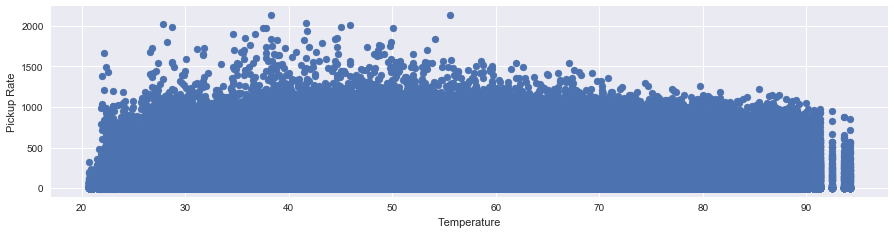

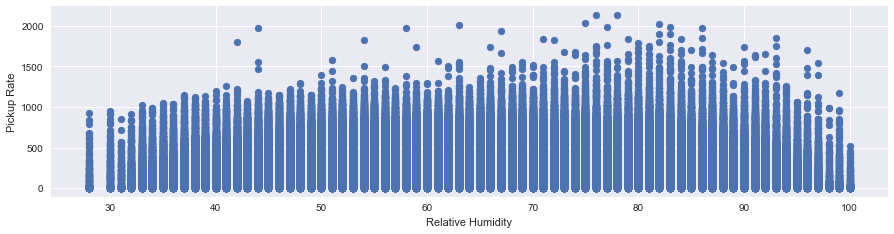

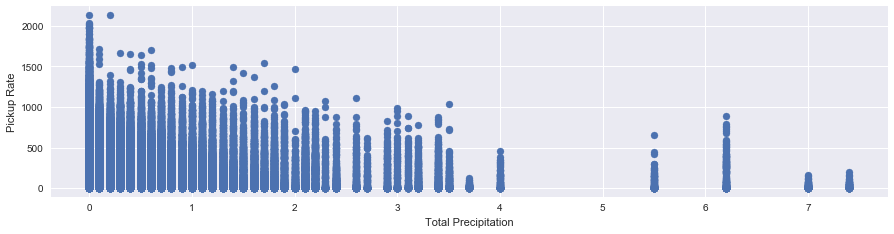

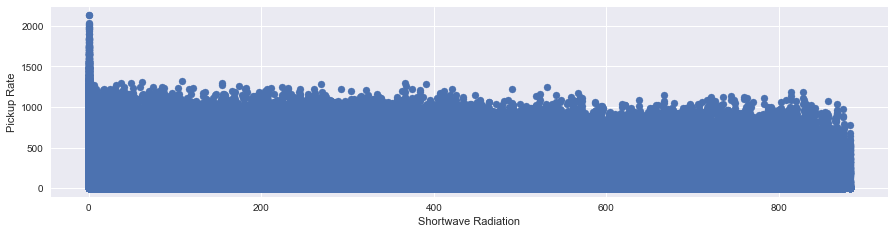

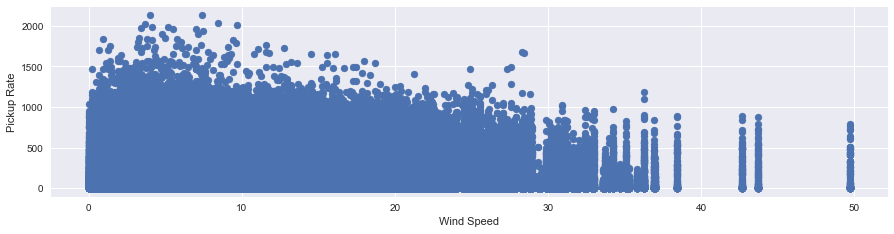

In [0]:
plt.scatter(x='Temperature  [2 m above gnd]', y='counts', data=frame)
plt.xlabel('Temperature')
plt.ylabel('Pickup Rate')
plt.show()

plt.scatter(x='Relative Humidity  [2 m above gnd]', y='counts', data=frame)
plt.xlabel('Relative Humidity')
plt.ylabel('Pickup Rate')
plt.show()

plt.scatter(x='Total Precipitation (high resolution)  [sfc]', y='counts', data=frame)
plt.xlabel('Total Precipitation')
plt.ylabel('Pickup Rate')
plt.show()

plt.scatter(x='Shortwave Radiation  [sfc]', y='counts', data=frame)
plt.xlabel('Shortwave Radiation')
plt.ylabel('Pickup Rate')
plt.show()

plt.scatter(x='Wind Speed  [10 m above gnd]', y='counts', data=frame)
plt.xlabel('Wind Speed')
plt.ylabel('Pickup Rate')
plt.show()

# 3. Model Training Preprocessing

85% of the samples will be used to train all the models, and 15% is reserved for test the models in next section.

In [0]:
#Split training and testing model: 85%
from sklearn.model_selection import train_test_split

model_train, model_test = train_test_split(frame, test_size = 0.15, random_state = 5)
model_train_x = model_train.reset_index().drop(['index','counts'], axis = 1)
model_test_x = model_test.reset_index().drop(['index','counts'], axis = 1)
model_train_y = model_train['counts']
model_test_y = model_test['counts']

## 3.1 Feature Encoding

Variable PULocationID can be treated as numeric feature and trained directly or treated as a categorical feature and encoded.

In [0]:
from category_encoders import TargetEncoder
from category_encoders import OneHotEncoder

##One-hot Encoding
enc1 = OneHotEncoder(cols = ['PULocationID']).fit(model_train_x, model_train_y)
model_train_x_1 = enc1.transform(model_train_x)
model_test_x_1 = enc1.transform(model_test_x)

##Target Encoding
enc2 = TargetEncoder(cols = ['PULocationID']).fit(model_train_x, model_train_y)
model_train_x_2 = enc2.transform(model_train_x)
model_test_x_2 = enc2.transform(model_test_x)

## 3.2 Feature Scaling

In [0]:
from sklearn import preprocessing

scale_lst1 = ['Temperature  [2 m above gnd]', 'Relative Humidity  [2 m above gnd]', 'Total Precipitation (high resolution)  [sfc]', 
             'Snowfall Amount (high resolution)  [sfc]','Sunshine Duration  [sfc]','Shortwave Radiation  [sfc]', 
             'Wind Speed  [10 m above gnd]','Wind Direction  [10 m above gnd]','Wind Gust  [sfc]',
             'pick_dayofweek','Month','Hour','Day',
             'PULocationID']
scale_lst2 = ['Temperature  [2 m above gnd]', 'Relative Humidity  [2 m above gnd]', 'Total Precipitation (high resolution)  [sfc]', 
             'Snowfall Amount (high resolution)  [sfc]','Sunshine Duration  [sfc]','Shortwave Radiation  [sfc]', 
             'Wind Speed  [10 m above gnd]','Wind Direction  [10 m above gnd]','Wind Gust  [sfc]',
             'pick_dayofweek','Month','Hour','Day']   #No 'PULocationID' if one-hot encoding.

#Standard scaling
model_train_x_3 = model_train_x_1.copy()     #One-hot Encoding + Standard Scaling
sc_scale = preprocessing.StandardScaler().fit(model_train_x_3[scale_lst2])
model_train_x_3[scale_lst2] = sc_scale.transform(model_train_x_3[scale_lst2])
model_test_x_3 = model_test_x_1.copy()
model_test_x_3[scale_lst2] = sc_scale.transform(model_test_x_3[scale_lst2])

model_train_x_4 = model_train_x_2.copy()     #Target Encoding + Standard Scaling
sc_scale2 = preprocessing.StandardScaler().fit(model_train_x_4[scale_lst1])
model_train_x_4[scale_lst1] = sc_scale2.transform(model_train_x_4[scale_lst1])
model_test_x_4 = model_test_x_2.copy()
model_test_x_4[scale_lst1] = sc_scale2.transform(model_test_x_4[scale_lst1])


##MinMax Scaling
model_train_x_5 = model_train_x_1.copy()     #One-hot Encoding + MinMax Scaling
mm_scale = preprocessing.MinMaxScaler().fit(model_train_x_5[scale_lst2])
model_train_x_5[scale_lst2] = mm_scale.transform(model_train_x_5[scale_lst2])
model_test_x_5 = model_test_x_1.copy()
model_test_x_5[scale_lst2] = mm_scale.transform(model_test_x_5[scale_lst2])

model_train_x_6 = model_train_x_2.copy()     #Target Encoding + MinMax Scaling
mm_scale2 = preprocessing.MinMaxScaler().fit(model_train_x_6[scale_lst1])
model_train_x_6[scale_lst1] = mm_scale2.transform(model_train_x_6[scale_lst1])
model_test_x_6 = model_test_x_2.copy()
model_test_x_6[scale_lst1] = mm_scale2.transform(model_test_x_6[scale_lst1])

# 4. Model Training

## 4.1 Lasso Linear Regression

#### 1) All features are linear

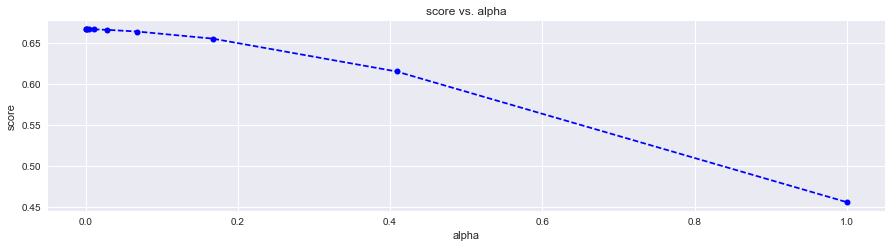

The optimaized alpha and score of Lasso linear is:  0.000316227766017 0.666307839285


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

lr_train_x = lr_train.reset_index().drop(['index','counts'], axis = 1)
lr_validate_x = lr_validate.reset_index().drop(['index','counts'], axis = 1)
lr_train_y = lr_train['counts']
lr_validate_y = lr_validate['counts']

lr_train_x = enc1.transform(lr_train_x)
lr_validate_x = enc1.transform(lr_validate_x)

lr_train_x[scale_lst2] = mm_scale.transform(lr_train_x[scale_lst2])
lr_validate_x[scale_lst2] = mm_scale.transform(lr_validate_x[scale_lst2])

alphas = np.logspace (-3.5, 0, num=10)
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(lr_train_x, lr_train_y)
    scores[i] = lasso.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print 'The optimaized alpha and score of Lasso linear is: ', opt_a, max_score 

In [0]:
# combine the validate data and training data, use the optimal alpha, re-train the model
model_train_x = model_train_x_5

lasso_f = Lasso()
lasso_f.set_params(alpha = opt_a)
lasso_f.fit(model_train_x, model_train_y)

# lasso_f is the Lasso model (linear feature), to be tested with final test data.

Lasso(alpha=0.00031622776601683794, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

#### 2) Ploynomial features

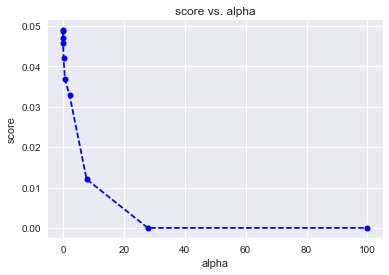

The optimaized alpha and score of Lasso polynomial is:  0.001 0.048942908713


In [0]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

lr_train_x = lr_train.reset_index().drop(['index','counts'], axis = 1)
lr_validate_x = lr_validate.reset_index().drop(['index','counts'], axis = 1)
lr_train_y = lr_train['counts']
lr_validate_y = lr_validate['counts']

lr_train_x = enc2.transform(lr_train_x)                   #Target Encoding
lr_validate_x = enc2.transform(lr_validate_x)

lr_train_x[scale_lst1] = mm_scale2.transform(lr_train_x[scale_lst1])        #MinMax Scale
lr_validate_x[scale_lst1] = mm_scale2.transform(lr_validate_x[scale_lst1])

lr_train_xp = poly.fit_transform(lr_train_x)              #Polynomial Added
lr_validate_xp = poly.fit_transform(lr_validate_x)


alphas = np.logspace (-3, 2, num=10)
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(lr_train_xp, lr_train_y)
    scores[i] = lasso.score(lr_validate_xp, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
        
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print 'The optimaized alpha and score of Lasso polynomial is: ', opt_a, max_score

# combine the validate data and training data, use the optimal alpha, re-train the model
lr_train_xp1 = poly.fit_transform(model_train_x)

lasso_fp = Lasso()
lasso_fp.set_params(alpha = opt_a)
lasso_fp.fit(lr_train_xp, model_train_y)

# lasso_fp is the Lasso model (polynomial feature), to be tested with test data.

In [0]:
# combine the validate data and training data, use the optimal alpha, re-train the model
model_train_x = model_train_x_6
lr_train_xp = poly.fit_transform(model_train_x)

lasso_fp = Lasso()
lasso_fp.set_params(alpha = opt_a)
lasso_fp.fit(lr_train_xp, model_train_y)

# lasso_fp is the Lasso model (polynomial feature), to be tested with test data.

## 4.2: Random Forest
Random forest with Gridsearch cross-validation is used. The 'mean_scores' is used to narrow down the paramenters of n_estimator (number of trees in the forest) and Max_depth (maximum depth of the tree).

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

rf_train_x = model_train_x_5
rf_train_y = model_train_y

param_grid = {
                 'n_estimators': [105, 120, 150],  #50, 25 => 0.70, 0.73； 52，27 => 0.72, 0.76; 100, 40 => 0.84
                 'max_depth': [42, 45, 50, 55, 60]
             }

rf = RandomForestRegressor(random_state=2, max_features = 'sqrt', verbose = 3)
grid_rf = GridSearchCV(rf, param_grid, cv=5)
grid_rf.fit(rf_train_x, rf_train_y)

building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  6.0min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   20.5s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  6.2min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   20.7s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  6.2min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   20.7s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  6.1min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   20.4s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  6.2min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   20.0s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  7.2min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   23.6s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  7.2min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   24.1s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  7.2min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   22.7s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  7.2min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   22.3s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  7.2min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   24.5s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  8.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   28.6s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  9.0min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   28.8s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  9.0min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   28.7s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  9.0min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   28.0s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  8.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   29.8s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  6.7min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   22.2s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  6.6min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   22.7s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.6s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  6.7min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   22.6s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  6.7min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   21.9s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  6.7min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   22.7s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  7.6min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   24.6s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  7.6min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   25.4s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  7.6min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   24.6s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  7.6min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   24.9s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  7.6min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   24.5s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  9.5min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   31.4s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  9.5min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    8.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   31.6s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  9.6min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   33.9s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  9.6min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   32.3s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  9.6min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   31.5s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  7.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   24.7s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  7.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   23.9s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.4s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  7.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   24.6s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.4s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  7.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   25.4s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  7.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   25.4s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  8.4min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   28.4s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  8.4min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   28.1s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  8.4min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   28.1s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  8.4min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   27.7s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  8.4min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   28.7s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.2s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 10.4min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   10.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   39.6s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 10.5min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   10.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   39.9s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.4s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 10.5min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   12.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   39.9s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.2s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 10.5min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    9.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   40.1s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.6s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 10.4min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   37.4s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  7.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   26.5s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  7.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   26.2s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  7.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   27.5s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  7.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   26.7s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.8s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  7.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   27.2s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  9.0min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   12.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   35.2s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  9.0min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   10.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   32.4s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  8.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   10.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   33.5s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  9.0min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   10.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   35.6s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  9.0min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    8.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   33.9s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 11.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   14.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   44.3s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.8s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 11.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   14.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   44.9s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 11.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   15.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   44.8s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.8s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 11.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   15.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   45.4s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 11.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   15.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   45.0s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  8.4min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   31.5s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  8.5min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    8.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   31.0s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  8.5min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   30.3s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.8s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  8.4min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   31.0s finished


building tree 1 of 105


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


building tree 2 of 105


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s


building tree 3 of 105
building tree 4 of 105
building tree 5 of 105
building tree 6 of 105
building tree 7 of 105
building tree 8 of 105
building tree 9 of 105
building tree 10 of 105
building tree 11 of 105
building tree 12 of 105
building tree 13 of 105
building tree 14 of 105
building tree 15 of 105
building tree 16 of 105
building tree 17 of 105
building tree 18 of 105
building tree 19 of 105
building tree 20 of 105
building tree 21 of 105
building tree 22 of 105
building tree 23 of 105
building tree 24 of 105
building tree 25 of 105
building tree 26 of 105
building tree 27 of 105
building tree 28 of 105
building tree 29 of 105
building tree 30 of 105
building tree 31 of 105
building tree 32 of 105
building tree 33 of 105
building tree 34 of 105
building tree 35 of 105
building tree 36 of 105
building tree 37 of 105
building tree 38 of 105
building tree 39 of 105
building tree 40 of 105
building tree 41 of 105
building tree 42 of 105
building tree 43 of 105
building tree 44 of 105

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  8.5min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:   31.9s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  9.5min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   11.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   37.5s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  9.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    9.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   37.9s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.7s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  9.5min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   12.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   39.0s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.6s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  9.8min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   20.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   48.0s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  9.5min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   15.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   41.0s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 11.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   18.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   54.5s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 12.1min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   19.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   52.4s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 11.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   20.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   55.2s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 11.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   19.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   52.3s finished


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 12.2min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   22.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   54.0s finished


building tree 1 of 120


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


building tree 2 of 120


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.2s remaining:    0.0s


building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 12.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=2,
           verbose=3, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [105, 120, 150], 'max_depth': [42, 45, 50, 55, 60]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [0]:
pd.DataFrame(grid_rf.cv_results_).sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
13,580.38,14.94,0.92,0.97,60,120,"{u'n_estimators': 120, u'max_depth': 60}",1,0.91,0.97,0.92,0.97,0.92,0.97,0.92,0.97,0.92,0.97,9.77,3.78,0.00,0.00
14,730.46,21.52,0.92,0.97,60,150,"{u'n_estimators': 150, u'max_depth': 60}",2,0.91,0.97,0.92,0.97,0.91,0.96,0.92,0.97,0.92,0.97,7.69,1.34,0.00,0.00
12,515.10,9.58,0.91,0.97,60,105,"{u'n_estimators': 105, u'max_depth': 60}",3,0.91,0.97,0.91,0.97,0.91,0.96,0.92,0.97,0.92,0.97,1.10,0.25,0.00,0.00
10,548.35,11.27,0.91,0.96,55,120,"{u'n_estimators': 120, u'max_depth': 55}",4,0.91,0.96,0.90,0.95,0.91,0.96,0.91,0.96,0.91,0.95,2.09,1.14,0.00,0.00
11,685.20,16.08,0.91,0.96,55,150,"{u'n_estimators': 150, u'max_depth': 55}",5,0.91,0.96,0.90,0.95,0.91,0.96,0.91,0.96,0.91,0.95,1.78,0.55,0.00,0.00
9,483.03,8.01,0.91,0.96,55,105,"{u'n_estimators': 105, u'max_depth': 55}",6,0.90,0.96,0.90,0.95,0.91,0.96,0.91,0.96,0.91,0.95,0.92,0.19,0.00,0.00
7,509.84,7.94,0.89,0.94,50,120,"{u'n_estimators': 120, u'max_depth': 50}",7,0.89,0.94,0.89,0.94,0.89,0.94,0.89,0.94,0.89,0.94,0.66,0.13,0.00,0.00
8,635.62,11.32,0.89,0.94,50,150,"{u'n_estimators': 150, u'max_depth': 50}",8,0.89,0.94,0.89,0.94,0.89,0.94,0.89,0.94,0.89,0.94,1.49,1.36,0.00,0.00
6,447.18,7.01,0.89,0.94,50,105,"{u'n_estimators': 105, u'max_depth': 50}",9,0.89,0.94,0.89,0.94,0.89,0.94,0.89,0.94,0.89,0.94,1.46,0.08,0.00,0.00
4,465.15,7.42,0.87,0.92,45,120,"{u'n_estimators': 120, u'max_depth': 45}",10,0.87,0.92,0.87,0.92,0.87,0.92,0.87,0.92,0.87,0.92,0.93,0.34,0.00,0.00


In [0]:
grid_rf.best_params_ 

{'max_depth': 60, 'n_estimators': 120}

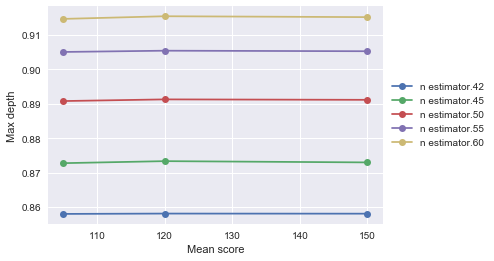

In [0]:
# plot the effect of different number of trees and maximum tree-depth druing cross validation 
scores = [x[1] for x in grid_rf.grid_scores_]
n_est = [105, 120, 150]
m_depth=[42, 45, 50, 55, 60]
scores = np.array(scores).reshape(len(m_depth), len(n_est))
fig = plt.figure()
ax = plt.subplot(111)
for ind, i in enumerate(m_depth):
    plt.plot(n_est, scores[ind], '-o', label='n estimator.' + str(i),)
    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Mean score')
plt.ylabel('Max depth')
plt.grid(True)
plt.show()
# savefig('rf_1')

** The best rf model that I have tried so far is n_estimator = 80, and max_depth = 120.**

In [0]:
rf = RandomForestRegressor(random_state=2, max_features = 'sqrt', max_depth= 80, n_estimators=120)
rf.fit(rf_train_x, rf_train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=120, n_jobs=1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)

# 5: Model Evaluation
Test data is the reserved 15% of the whole dataset, and has never been seen by the above models.

### 5.1 Lasso test with linear features (lasso_f)

In [0]:
model_test_x = model_test_x_5    #model_text_x after One-hot Encoding and MinMax Scaling
# Lasso_f test (with linear features)

lasso_f_score = lasso_f.score(model_test_x, model_test_y)
pred_y = lasso_f.predict(model_test_x)

# The mean squared error and root mean square error
MSE_lasso_f = mean_squared_error(model_test_y, pred_y)
RMSE_lasso_f = sqrt(mean_squared_error(model_test_y, pred_y))

print 'lasso_f score: ', lasso_f_score
print 'Mean square error of lasso_f: ', MSE_lasso_f
print 'Root mean squared error of lasso_f:', RMSE_lasso_f
# print ('Coefficients of lasso_f: ', lasso_f.coef_)

lasso_f score:  0.667605126386
Mean square error of lasso_f:  10843.3396158
Root mean squared error of lasso_f: 104.131357505


### 5.2 Random forest test (rf)

In [0]:
model_test_x = model_test_x_5 #encoding and scaling transformation

rf_score = rf.score(model_test_x, model_test_y)

pred_y = rf.predict(model_test_x)
MSE_rf = mean_squared_error(model_test_y, pred_y)
RMSE_rf = sqrt(mean_squared_error(model_test_y, pred_y))

# The mean squared error and root mean square error
print 'rf score: ', rf_score
print 'Mean square error of rf: ', MSE_rf
print 'Root mean squared error of rf:', RMSE_rf
# print('Coefficients: \n', ridge_fp.coef_)

rf score:  0.936435549915
Mean square error of rf:  2073.59070332
Root mean squared error of rf: 45.5366962275


### 5.3 Comparison of the models
Compared the max_score, mean squared error (MSE), and root mean squared error (RMSE) of 2 models. Random forest model rf returns the beset prediction accuracy.
<br>
Random Forest performs better.

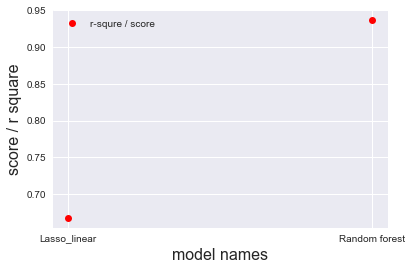

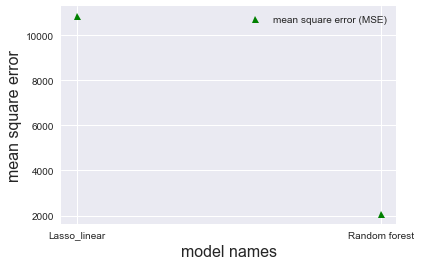

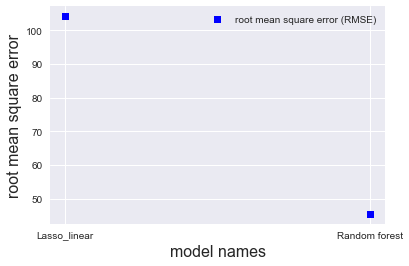

In [0]:
lst_score = [lasso_f_score, 
             #lasso_fp_score, 
             rf_score
            ]
MSE_lst =  [MSE_lasso_f,
            #MSE_lasso_fp,
            MSE_rf
           ]
RMSE_lst =  [RMSE_lasso_f,
             #, RMSE_lasso_fp,
             RMSE_rf
            ]
model_lst = ['Lasso_linear',
             #,'Lasso poly', 
             'Random forest'
            ]

plt.figure(1)
plt.plot(np.arange(2), lst_score, 'ro')
plt.xticks(np.arange(2),model_lst)
plt.legend(loc = 9)
plt.legend(['r-squre / score'])
plt.xlabel('model names',fontsize =16)
plt.ylabel('score / r square', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(2)
plt.plot(np.arange(2), MSE_lst, 'g^')
plt.xticks(np.arange(2),model_lst)
plt.legend(loc = 9)
plt.legend(['mean square error (MSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('mean square error', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(3)
plt.plot(np.arange(2), RMSE_lst, 'bs')
plt.xticks(np.arange(2),model_lst)
plt.legend(loc = 9)
plt.legend(['root mean square error (RMSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('root mean square error', fontsize =16)
plt.grid(True)
plt.show()

# 6: Feature importance
Random forest(RF) shows the best prediction accuracy. Therefore, the feature importance will be extracted from the RF model.
Conclusion: PULocationID contributes the most and is much larger than all other features. Excluding PULocationID, the importance of other features were shown in the barchart.

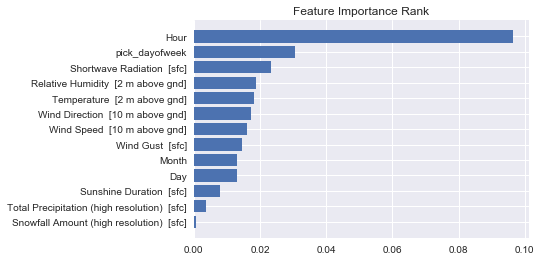

In [0]:
rf_test_x = model_test_x_5

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_name = rf_test_x.columns.get_values()

importance_df = pd.DataFrame({'name': feature_name, 'importance': importances})
importance_df['YN'] = [x[:12] == 'PULocationID' for x in importance_df.name.values]
importance_df.append({'importance':sum(importance_df.loc[importance_df.YN].importance), 
                      'name':'PULocationID',
                      'YN': False}, ignore_index=True)
importance_df = importance_df.loc[importance_df.YN == False].sort_values(['importance'])

plt.figure(1)
plt.barh(np.arange(importance_df.shape[0]), importance_df.importance)
plt.yticks(np.arange(importance_df.shape[0]), importance_df.name)
plt.title('Feature Importance Rank')
plt.show()